POLYGON ((372.2564410669492 114.6554772595682, 281.0032354229271 -846.5077506084805, 169.7539996163042 81.9172725307007, 358.6672322492496 134.5916875938962, 372.2564410669492 114.6554772595682))
POLYGON ((358.6672322492496 134.5916875938962, 169.7539996163042 81.9172725307007, 131.9787694177804 152.8877357750182, 142.5566287523281 184.7776064857419, 250.3997577041752 235.7096576260865, 333.2664584972573 191.8813378200674, 358.6672322492496 134.5916875938962))
POLYGON ((385.9596977215347 263.3445812554237, 333.2664584972573 191.8813378200674, 250.3997577041752 235.7096576260865, 198.0436983460503 515.0108882565639, 385.9596977215347 263.3445812554237))
POLYGON ((131.9787694177804 152.8877357750182, -313.5697609542376 -85.11327060104199, 85.849651201668 242.4730203522404, 142.5566287523281 184.7776064857419, 131.9787694177804 152.8877357750182))


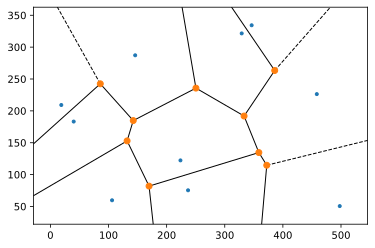

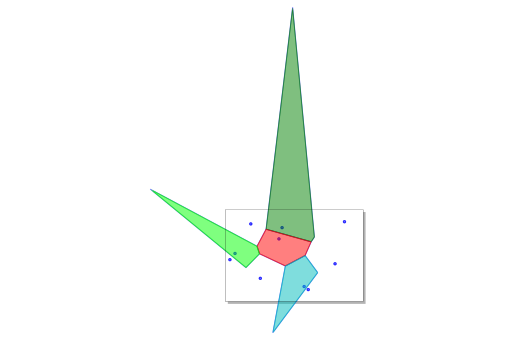

In [18]:
import datetime
import math
from itertools import product
from random import choices, randint
from typing import List, Tuple

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.affinity as affinity
import shapely.geometry as geo
import shapely.ops as ops
import vsketch
from sklearn.neighbors import NearestNeighbors

DISPLAY_RATIO = 1.5

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def display(sketch):
    return sketch.display("matplotlib", fig_size=(6*DISPLAY_RATIO,4*DISPLAY_RATIO))

vsk = vsketch.Vsketch()
vsk.size("6x4in", center=False)

W = vsk.width
H = vsk.height

np.random.seed(24601)
points = np.random.random((10, 2))
points = list(map(lambda p: np.multiply(p, [W, H]), points))

vor = Voronoi(points)
voronoi_plot_2d(vor)

# clamp to bounds
regions, vertices = voronoi_finite_polygons_2d(vor)

lines = [
    geo.LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]

for point in points:
    vsk.fill(1)
    vsk.stroke(1)
    vsk.geometry(geo.Point(*point).buffer(5))


index = 2
for poly in ops.polygonize(lines):
    #vsk.stroke(index + 1)
    print(poly)
    vsk.fill(index)
    vsk.geometry(poly)
    index += 1

display(vsk)